In [2]:
%pylab inline
import pickle as pk

Populating the interactive namespace from numpy and matplotlib


In [3]:
!ls -lrt *.pkl

-rw-r--r--  1 yoavfreund  staff  600579404 Apr  7 10:24 labels.pkl
-rw-r--r--  1 yoavfreund  staff  223719807 Apr 23 20:05 centered_data.pkl
-rw-r--r--  1 yoavfreund  staff  600579404 Apr 23 21:29 labels_centered.pkl


In [4]:
#labels is the labels or the neighbors of a test point
#It consists of a list of 1000 arrays each corresponding to one test examples
# each array contains 60000 elements which are the labels of the 60000 trainining examples sorted by increasing 
# distance to the test example.

with open('labels_centered.pkl','br') as pklfile:
    labels=pk.load(pklfile)
len(labels), labels[0].shape

(10000, (60000,))

In [5]:
import pickle as pk
with open('centered_data.pkl','rb') as pkfile:
    D=pk.load(pkfile)
D.keys()
 
train_images = D['train_images']
train_labels = D['train_labels']
test_images = D['test_images']
test_labels = D['test_labels']

train_images=np.array(train_images)
test_images = np.array(test_images)

In [6]:
def find_sig(x,thr=5):
    """Find the first entry of x that is larger than thr.
    if found : return the index
    if not found return np.NaN"""
    f=np.nonzero(x>thr)[0]
    if f.shape[0]==0:
        return np.NaN
    else:
        return f[0]

In [7]:
x=arange(0,6,0.1)
find_sig(x,3)

31

In [8]:
k=3
type(k) is int

True

In [9]:
from collections import Counter
def find_label_knn(test_index,k=5):
    L=labels[test_index]
    C=list(Counter(L[:k]).items())
    S=sorted(C,key=lambda x:x[1],reverse=True)
    return np.array(S).transpose()

In [10]:
def find_label_adaptive(test_index,thr=4):
    """Find label of test example test_index using adaptive k NN"""
    _range=1000
    C=[]
    sig=[]
    P=np.zeros([10,_range])
    L=labels[test_index]
    scale=arange(1,_range+1,1)
    for i in range(10):
        C.append(np.cumsum(L==i))
        P[i,:]=(C[-1][:_range]-(scale/10))/sqrt(scale)
        sig.append(find_sig(P[i,:],thr=thr))
    sig=np.array(sig)
    no_sig = np.sum(~np.isnan(sig)) #count how many labels reached significance
    if no_sig==0:
        return np.array([[-1,-1],[-1,-1]])
    predicted_label=np.nanargmin(sig)
    stopping_time=int(sig[predicted_label])
    sigs_at_stop = P[:,stopping_time]
    I=argsort(sigs_at_stop)
    Sigs=sigs_at_stop[I]
    prediction=np.array([I[Sigs>0],Sigs[Sigs>0]],dtype=np.int16)
    return prediction[:,-1::-1]

In [11]:
def compute_errs(method="adaptive",**kwargs):
    errs=np.zeros([4,11])
    n=test_labels.shape[0]
    for i in range(n):
        if method=='adaptive':
            pred_label=find_label_adaptive(i,**kwargs)
        else:
            pred_label=find_label_knn(i,**kwargs)

        prediction=int(pred_label[0,0])
        err = 0 #prediction error
        labelSet=set(pred_label[0,:])
        if prediction != test_labels[i]:
            err=1 # incorrect prediction
        if test_labels[i] in labelSet:
            err+=2 # prediction in prediction set
        multi=pred_label.shape[1]
        if prediction==-1:
            multi=0
            err=1
        errs[err,multi]+=1
        if i%100==0:
            print('\r',i,end='')
    errs=np.array(errs,dtype=np.int16)
    print()       

    print('size of set',''.join(["%6d"%x for x in range(11)]))
    print('total      ',''.join(["%6d"%x for x in np.sum(errs,axis=0)]))
    print('incorrect  ',''.join(["%6d"%x for x in np.sum(errs,axis=0)-errs[2,:]]))
    #print('in set     ',''.join(["%6d"%x for x in errs[2,:]+errs[3,:]]))
    print('not in set ',''.join(["%6d"%x for x in errs[0,:]+errs[1,:]]))
 

In [12]:
for k in range(1,11):
    print('='*40,'knn with k=',k)
    errs=compute_errs('knn',k=k)

for theta in range(1,5):
    print('='*40,'adaptive NN with theta=',theta)
    errs=compute_errs('adaptive',thr=theta)

======================================== knn with k= 1
 9900
size of set      0     1     2     3     4     5     6     7     8     9    10
total            0 10000     0     0     0     0     0     0     0     0     0
incorrect        0   331     0     0     0     0     0     0     0     0     0
not in set       0   331     0     0     0     0     0     0     0     0     0
======================================== knn with k= 2
 9900
size of set      0     1     2     3     4     5     6     7     8     9    10
total            0  9545   455     0     0     0     0     0     0     0     0
incorrect        0   136   195     0     0     0     0     0     0     0     0
not in set       0   136    53     0     0     0     0     0     0     0     0
======================================== knn with k= 3
 9900
size of set      0     1     2     3     4     5     6     7     8     9    10
total            0  9303   613    84     0     0     0     0     0     0     0
incorrect        0    85   

[2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 30]


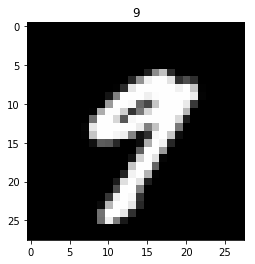

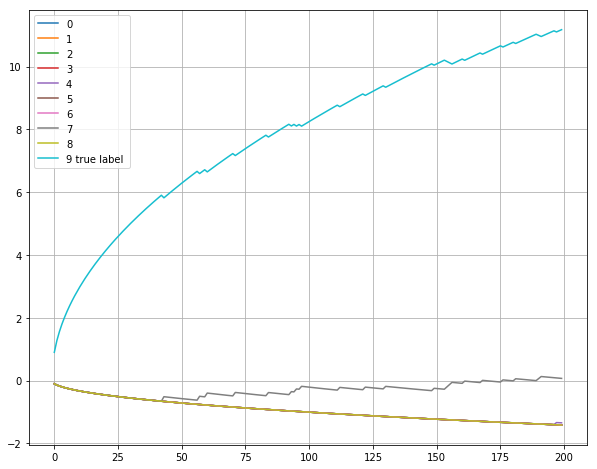

In [78]:
i=8520 # a 4 that looks like a 9
i=20
#i=23
#i=320

threshold=5
L=labels[i]
true_label=test_labels[i]
imshow(test_images[i,:,:],cmap='gray')
title(str(true_label))

figure(figsize=[10,8])
_range=200
C=[]
sig=[]
scale=arange(1,_range+1,1)
for i in range(10):
    C.append(np.cumsum(L==i))
    P=(C[-1][:_range]-(scale/10))/sqrt(scale)
    sig.append(find_sig(P))
    _name=str(i)
    if i==true_label:
        _name+= ' true label '
    plot(P,label=_name)
legend()
grid()
print(sig)

In [40]:
P[:10]

array([-0.1       ,  0.56568542,  0.40414519,  0.3       ,  0.2236068 ,
        0.16329932,  0.49135381,  0.42426407,  0.36666667,  0.63245553])

In [54]:
np.nonzero(P>1)[0].shape

(73,)